# María Isabel Ortiz Naranjo - Carné 18176

# Luis Alejandro Urbina Hernández - Carné 18473

Catedrático: Jorge Yass Coy

Cátedra: Security Data Science


In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import pandas_profiling as pp
from pandas_profiling import ProfileReport

import sklearn
from sklearn import metrics, model_selection, tree

## Exploración de datos

__Carga del dataset y mostrar las primeras 5 observaciones__

In [3]:
df = pd.read_csv("dataset_pishing.csv")

In [4]:
print(df.head(100))

                                                  url  ip  nb_www  nb_com  \
0               http://www.crestonwood.com/router.php   0       1       0   
1   http://shadetreetechnology.com/V4/validation/a...   1       0       0   
2   https://support-appleld.com.secureupdate.duila...   1       0       1   
3                                  http://rgipt.ac.in   0       0       0   
4   http://www.iracing.com/tracks/gateway-motorspo...   0       1       0   
..                                                ...  ..     ...     ...   
95            https://www.facebook.com/thekeyboardcat   0       1       0   
96                       https://www.soul-flower.com/   0       1       0   
97                   http://www.tech-faq.com/mms.html   0       1       0   
98                                   http://sniz.porn   0       0       0   
99                            http://enerclim.com/cs/   0       0       0   

    nb_dslash  http_in_path  punycode  port  tld_in_path  tld_in_subdomain 

__Muestre la cantidad de observaciones etiquetadas en la columna status como “legit” y como “pishing”. ¿Está balanceado el dataset?__

***R:*** Si se encuentra balanceado el dataset, pues hay 5715 observaciones por cada una de las etiquetas.

In [5]:
df['status'].value_counts()

legitimate    5715
phishing      5715
Name: status, dtype: int64

## Derivación de características

__Derivar las características basadas en el dominio: f1, f2, f4 – f20, f25, f26 y f27.__

In [6]:
# f1

def getUrlLength(x):
    return len(x)

# f2

def getHostnameLength(x):
    pattern = "//(.*?)/"
    substring = re.search(pattern, x)
    try:
        substring = substring.group(1)
    except:
        return 0
    
    return len(substring)

# f4-f20

def countSpecialCharacters(x):
    x = x.lower()
    success_pattern = re.compile(r'\%20')
    success_list = re.findall(success_pattern, x)
    x = x.replace("%20", "")
    pattern = re.compile(r'\.|\-|\@|\?|\&|\||\=|\_|\~|\%|\/|\*|\:|\,|\;|\$|\s')
    symbols = re.findall(pattern, x)
    return len(success_list) + len(symbols)

# f25

def hasHttpsToken(x):
    if ("https" in x):
        return 1
    else:
        return 0
    
# f26 y #f27

def ratioDigitsToText (x):
    digits = re.findall('\d', x)
    try:
        proportion = len(digits) / len(x)
    except:
        proportion = 0
    return proportion

def getHostname(x):
    pattern = "//(.*?)/"
    substring = re.search(pattern, x).group(1)
    return substring


__Generar nuevas columnas en dataset__

In [7]:
# Generate new columns (url_length and hostname_length)

df['url_length'] = df['url'].apply(getUrlLength)
df['hostname_length'] = df['url'].apply(getHostnameLength)


# delete rows that have a 0 in hostname_length meaning the hostname is incomplete
df = df.drop(df.index[df['hostname_length'] == 0])

# Generate rest of the columns

df['hostname'] = df['url'].apply(getHostname)
df['special_characters_count'] = df['url'].apply(countSpecialCharacters)
df['has_https'] = df['url'].apply(hasHttpsToken)
df['ratioDigitsToTextUrl'] = df['url'].apply(ratioDigitsToText)
df['ratioDigitsToTextHostname'] = df['hostname'].apply(ratioDigitsToText)

__Muestre un nuevo ejemplo de cinco observaciones donde se visualicen algunas de las columnas nuevas.__

In [8]:
df.head(5)

,url,ip,nb_www,nb_com,nb_dslash,http_in_path,punycode,port,tld_in_path,tld_in_subdomain,...,google_index,page_rank,status,url_length,hostname_length,hostname,special_characters_count,has_https,ratioDigitsToTextUrl,ratioDigitsToTextHostname
0,http://www.crestonwood.com/router.php,0,1,0,0,0,0,0,0,0,...,1,4,legitimate,37,19,www.crestonwood.com,7,0,0.000000,0.0
1,http://shadetreetechnology.com/V4/validation/a...,1,0,0,0,0,0,0,0,0,...,1,2,phishing,77,23,shadetreetechnology.com,7,0,0.220779,0.0
2,https://support-appleld.com.secureupdate.duila...,1,0,1,0,0,0,0,0,1,...,1,0,phishing,126,50,support-appleld.com.secureupdate.duilawyeryork...,19,1,0.150794,0.0
4,http://www.iracing.com/tracks/gateway-motorspo...,0,1,0,0,0,0,0,0,0,...,0,6,legitimate,55,15,www.iracing.com,10,0,0.000000,0.0
5,http://appleid.apple.com-app.es/,0,0,1,0,0,0,0,0,0,...,1,0,phishing,32,24,appleid.apple.com-app.es,8,0,0.000000,0.0


## Preprocesamiento

__Realice las modificaciones necesarias para convertir la variable categórica status a una variable
binaria.__

In [9]:
df['status'] = df['status'].replace(to_replace='legitimate', value=1)
df['status'] = df['status'].replace(to_replace='phishing', value=0)

__Elimine la columna de dominio.__

In [10]:
df.drop('url', axis=1, inplace=True)

df_final = df

In [11]:
df.head()

,ip,nb_www,nb_com,nb_dslash,http_in_path,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,...,google_index,page_rank,status,url_length,hostname_length,hostname,special_characters_count,has_https,ratioDigitsToTextUrl,ratioDigitsToTextHostname
0,0,1,0,0,0,0,0,0,0,0,...,1,4,1,37,19,www.crestonwood.com,7,0,0.000000,0.0
1,1,0,0,0,0,0,0,0,0,0,...,1,2,0,77,23,shadetreetechnology.com,7,0,0.220779,0.0
2,1,0,1,0,0,0,0,0,1,0,...,1,0,0,126,50,support-appleld.com.secureupdate.duilawyeryork...,19,1,0.150794,0.0
4,0,1,0,0,0,0,0,0,0,0,...,0,6,1,55,15,www.iracing.com,10,0,0.000000,0.0
5,0,0,1,0,0,0,0,0,0,0,...,1,0,0,32,24,appleid.apple.com-app.es,8,0,0.000000,0.0


## Visualización de resultados

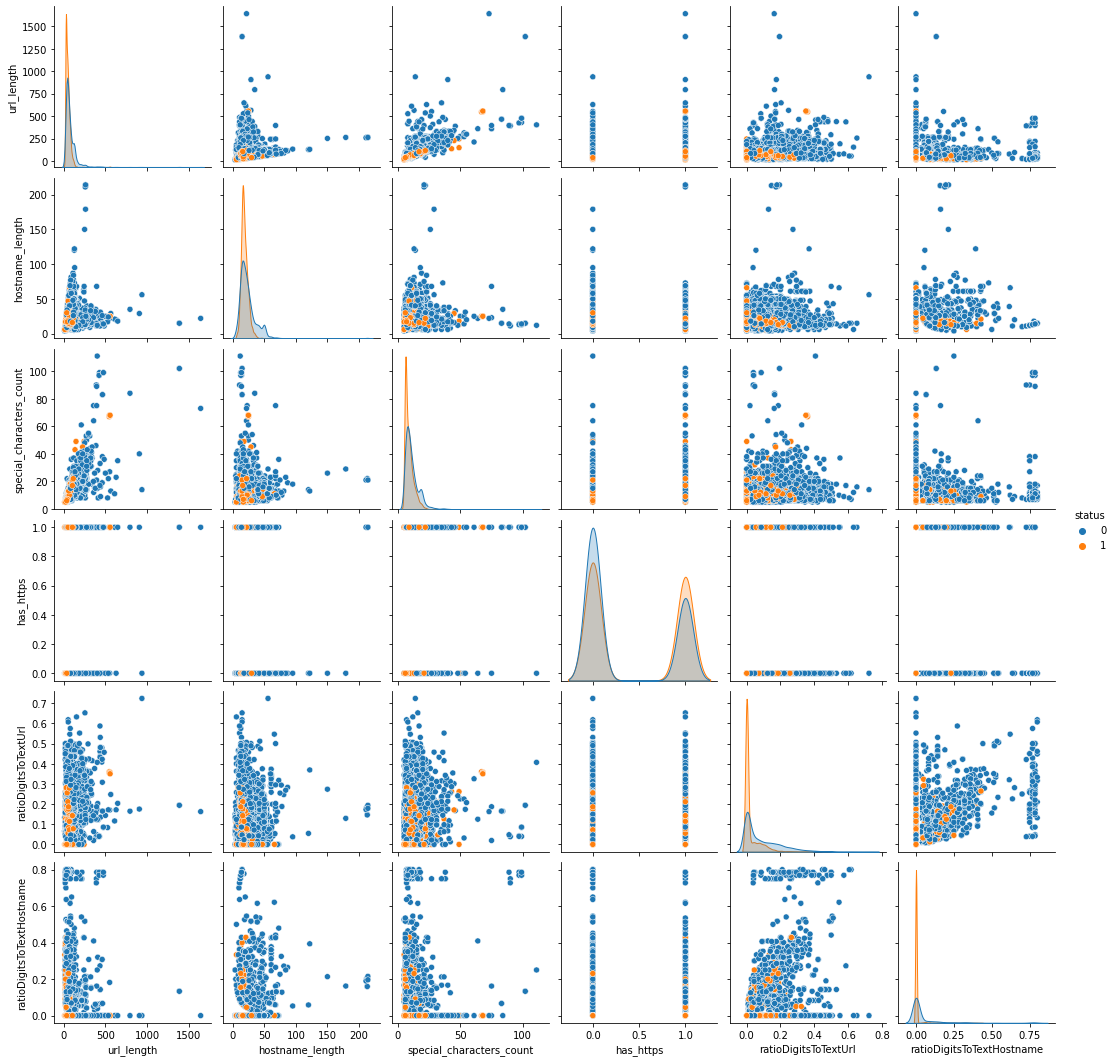

In [12]:
variables_names = ['url_length', 'hostname_length', 'special_characters_count', 'has_https', 'ratioDigitsToTextUrl', 'ratioDigitsToTextHostname']
sns.pairplot(df_final, hue='status', vars=variables_names)
plt.show()

In [13]:
new_df = df_final[['url_length', 'hostname_length', 'special_characters_count', 'has_https', 'ratioDigitsToTextUrl', 'ratioDigitsToTextHostname', 'status']].copy()
new_df.head()

,url_length,hostname_length,special_characters_count,has_https,ratioDigitsToTextUrl,ratioDigitsToTextHostname,status
0,37,19,7,0,0.000000,0.0,1
1,77,23,7,0,0.220779,0.0,0
2,126,50,19,1,0.150794,0.0,0
4,55,15,10,0,0.000000,0.0,1
5,32,24,8,0,0.000000,0.0,0


In [14]:
profile = ProfileReport(new_df, title='Reporte Status Final')
profile.to_file('Reporte Status Final.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 125.44it/s]


## Selección de Características 

In [32]:
df_car = df[['url_length', 'hostname_length', 'special_characters_count', 'has_https', 'ratioDigitsToTextUrl', 'ratioDigitsToTextHostname', 'status']]

In [33]:
df_car.drop_duplicates()

,url_length,hostname_length,special_characters_count,has_https,ratioDigitsToTextUrl,ratioDigitsToTextHostname,status
0,37,19,7,0,0.000000,0.000000,1
1,77,23,7,0,0.220779,0.000000,0
2,126,50,19,1,0.150794,0.000000,0
4,55,15,10,0,0.000000,0.000000,1
5,32,24,8,0,0.000000,0.000000,0
...,...,...,...,...,...,...,...
11423,85,15,16,0,0.047059,0.000000,0
11424,62,15,13,0,0.000000,0.000000,1
11426,84,18,15,0,0.023810,0.000000,0
11427,105,16,17,1,0.142857,0.000000,1


## Implementacion del modelo

In [81]:
target = new_df['status']
feature_matrix = new_df.drop(['status'], axis=1)

print('Final features:', feature_matrix.columns)
feature_matrix.head()

feature_matrix_train, feature_matrix_test, target_train, target_test = model_selection.train_test_split(feature_matrix, target, test_size=0.30, train_size = 0.55, random_state=70)

Final features: Index(['url_length', 'hostname_length', 'special_characters_count',
       'has_https', 'ratioDigitsToTextUrl', 'ratioDigitsToTextHostname'],
      dtype='object')


In [82]:
target.to_csv("target_phishing.csv")
feature_matrix.to_csv("feature_matrix_phishing.csv")


In [83]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(feature_matrix_train, target_train)

In [84]:
print(feature_matrix_train.count())

url_length                   5935
hostname_length              5935
special_characters_count     5935
has_https                    5935
ratioDigitsToTextUrl         5935
ratioDigitsToTextHostname    5935
dtype: int64


In [85]:
print(feature_matrix_test.count())

url_length                   3238
hostname_length              3238
special_characters_count     3238
has_https                    3238
ratioDigitsToTextUrl         3238
ratioDigitsToTextHostname    3238
dtype: int64


In [86]:
target_pred = clf.predict(feature_matrix_test)

In [87]:
print(metrics.accuracy_score(target_test, target_pred))
print('Matriz de Confusion', metrics.confusion_matrix(target_test, target_pred))
print(metrics.classification_report(target_test, target_pred, target_names=['legitimate', 'phishing']))


0.7337862878319951
Matriz de Confusion [[1178  459]
 [ 403 1198]]
              precision    recall  f1-score   support

  legitimate       0.75      0.72      0.73      1637
    phishing       0.72      0.75      0.74      1601

    accuracy                           0.73      3238
   macro avg       0.73      0.73      0.73      3238
weighted avg       0.73      0.73      0.73      3238



## Responda las siguientes preguntas: 
1. ¿Cuál es el impacto de clasificar un sitio legítimo como Pishing?  
Que realmente las personas no tienen la suficiente confianza para ingresar los datos a un sitio que verdaderamente si los va a usar a conciencia. 

2. ¿Cuál es el impacto de clasificar un sitio de Pishing como legítimo? 
Arriesgarse que su informacion personal este mal utilizada, y causa muchas estafas, robos entre otras cosas.

3. En base a las respuestas anteriores, ¿Qué métrica elegiría para comparar modelos similares 
de clasificación de pishing? 
Eligiria f1-score, que considera tanto la precisión como la recuperación para calcular la puntuación. La puntuación F1 se puede interpretar como un promedio ponderado de los valores de precisión y recuperación, donde una puntuación F1 alcanza su mejor valor en 1 y el peor valor en 0.

4. ¿Es necesaria la intervención de una persona humana en la decisión final de clasificación?
Si, para tomar diferentes parametros. Al final, esto solo da resultados pues se toma una decision basado en muchos datos. Pero no siempre se tiene el 100% de certeza.  